In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import clean_data
import random

init_cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
             'MEAN_MOTION', 'NORAD_CAT_ID', 'EPOCH', 'SUNSPOTS_1D', 'SUNSPOTS_3D', 'SUNSPOTS_7D',
             'AIR_MONTH_AVG_TEMP', 'WATER_MONTH_AVG_TEMP',
            ]


def load_raw(name=None):
    if not name:
        train_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/../3_min/train.pkl' ) # Time: 25.7s
        test_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/../3_min/test.pkl' ) # Time: 5
        return {'train': train_df, 'test': test_df}
    elif name == 'train':
        return {name: pd.read_pickle(os.environ['GP_HIST_PATH'] + '/../3_min/train.pkl' )}
    elif name == 'test':
        return {name: pd.read_pickle(os.environ['GP_HIST_PATH'] + '/../3_min/test.pkl' )}

def create_save(perc, name=None):
    print('>>> Loading raw data')
    df_in = load_raw(name)

    df_out = []
    for name, df in df_in.items():
        print(f'>>> Truncating {name} data...')
        df = df[init_cols].reset_index(drop=True)  # 4s

        print(f'>>> Normalizing {name} data...')
        df = clean_data.normalize_all_columns(df) # 53.4s

        print(f'>>> Building {name} index map...')
        try:
            idx_map = clean_data.load_index_map(name=name, path='data')
        except:
            idx_map = clean_data.create_index_map(df, write=True, name=name, path='data') # 3min 29s

        print(f'>>> Building {name} inputs and labels')
        X,y = clean_data.build_xy(df, idx_map) # 59min 41s
        X = clean_data.normalize_epoch_diff(X, drop_epoch=False) # 19s

        print(f'>>> Saving {name} data')
        X.to_pickle(f'data/x_{name}1.pkl')
        y.to_pickle(f'data/y_{name}1.pkl')
        df_out.extend([X,y])
    
    return df_out

def load(perc, force_update=False):
    if not force_update:
        print('>>> Loading data')
        
        X_train = pd.read_pickle('data/x_train1.pkl')
        y_train = pd.read_pickle('data/y_train1.pkl')
        X_test = pd.read_pickle('data/x_test1.pkl')
        y_test = pd.read_pickle('data/y_test1.pkl')
        return X_train, y_train, X_test, y_test
    else:
        return create_save(perc)
        

perc = 0.05
force_update = False

X_train, y_train, X_test, y_test = load(perc, force_update)
print(f'>>> Complete')

>>> Loading raw data
>>> Truncating train data...
>>> Normalizing train data...
>>> Building train index map...
>>> Building train inputs and labels
>>> Saving train data
>>> Truncating test data...
>>> Normalizing test data...
>>> Building test index map...
>>> Building test inputs and labels
>>> Saving test data
>>> Complete


In [2]:
import train

configurations = {
    'model_identifier' : "full_1",
    'model_path' : './data',
    'device' : 'cpu',
    'random_seed' : 0,
    'lr' : 0.01,
    'momentum' : 0.9,
    'weight_decay' : 1e-6,
    'max_epochs' : 100,
    'do_validate' : True,
    'model_definition' : {
        'layer1' : 50, 'relu1' : True, #'drop1' : 0.2,
        'layer2' : 30, 'relu2' : True, #'drop2' : 0.2,
        'layer3' : 30, 'relu3' : True, #'drop3' : 0.2,
        'layer4' : 30, 'relu4' : True, #'drop4' : 0.5,
        'layer5' : 20, 'relu5' : True, #'drop5' : 0.5,
        'layer6' : 20, 'relu6' : True, #'drop6' : 0.5,
        'layer7' : 20, 'relu7' : True, #'drop7' : 0.5,
        'layer8' : 10, 'relu8' : True, #'drop8' : 0.5,
        'layer9' : 10, 'relu9' : True, #'drop9' : 0.5,
    },
    'train_params' : {
        'batch_size': 2000,
        'shuffle': True,
        'num_workers': 2,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 20000,
        'num_workers': 2,
        'pin_memory': True,
    },
}

In [ ]:
# After changes -- 27s (cpu)
cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY',
       'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'SUNSPOTS_1D',
       'SUNSPOTS_3D', 'SUNSPOTS_7D', 'AIR_MONTH_AVG_TEMP',
       'WATER_MONTH_AVG_TEMP', 'year', 'month_sin', 'month_cos', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos',
       'ms_sin', 'ms_cos', 'year_y', 'month_sin_y', 'month_cos_y',
       'hour_sin_y', 'hour_cos_y', 'minute_sin_y', 'minute_cos_y',
       'second_sin_y', 'second_cos_y', 'ms_sin_y', 'ms_cos_y',
       'epoch_day_diff', 'epoch_sec_diff', 'epoch_ms_diff']

model, mean_losses = train.train_model(X_train[cols], y_train, X_test[cols], y_test, configurations, force_train=False)

Loading existing model
NNModelEx(
  (net): Sequential(
    (0): Linear(in_features=37, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): ReLU()
    (8): Linear(in_features=30, out_features=20, bias=True)
    (9): ReLU()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): ReLU()
    (14): Linear(in_features=20, out_features=10, bias=True)
    (15): ReLU()
    (16): Linear(in_features=10, out_features=10, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10, out_features=6, bias=True)
  )
)


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/24385 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/24385 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/24385 [00:00<?, ?it/s]

Loading existing model


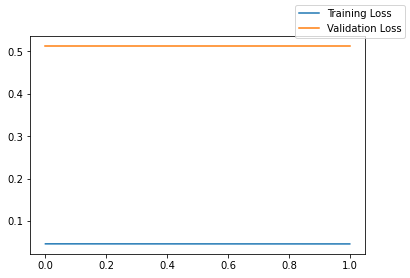

In [20]:
model, _, _, mean_losses, _ = train.load_model_with_config(configurations)
    
tl, vl = zip(*mean_losses)

fig,ax = plt.subplots()
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")

fig.legend()
plt.show()